In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from scipy.stats import trim_mean
from statsmodels import robust
from pandas import Series, DataFrame
from matplotlib import cm 
from matplotlib import font_manager, rc
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)    

import re
from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from lightgbm import LGBMClassifier

In [138]:
train = pd.read_csv('../data/train_data.csv')
test= pd.read_csv('../data/test_data.csv')
submission = pd.read_csv('../data/sample_submission.csv')
topic = pd.read_csv('../data/topic_dict.csv')

del train['index']
del test['index']
del submission['index']

### EDA

In [139]:
EDA = pd.merge(train, topic, on ='topic_idx'); EDA

,title,topic_idx,topic
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계
...,...,...,...
45649,창원 시내버스 노조 파업 투표 가결…30일 운행 멈춘다종합,2,사회
45650,남친과 함께 잔혹하게 동거인 학대 20대 여성 구속영장,2,사회
45651,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,사회
45652,답변하는 배기동 국립중앙박물관장,2,사회


In [140]:
EDA

,title,topic_idx,topic
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계
...,...,...,...
45649,창원 시내버스 노조 파업 투표 가결…30일 운행 멈춘다종합,2,사회
45650,남친과 함께 잔혹하게 동거인 학대 20대 여성 구속영장,2,사회
45651,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,사회
45652,답변하는 배기동 국립중앙박물관장,2,사회


#### (1) 각 토픽(주제)별 분포 확인 [Train 데이터]

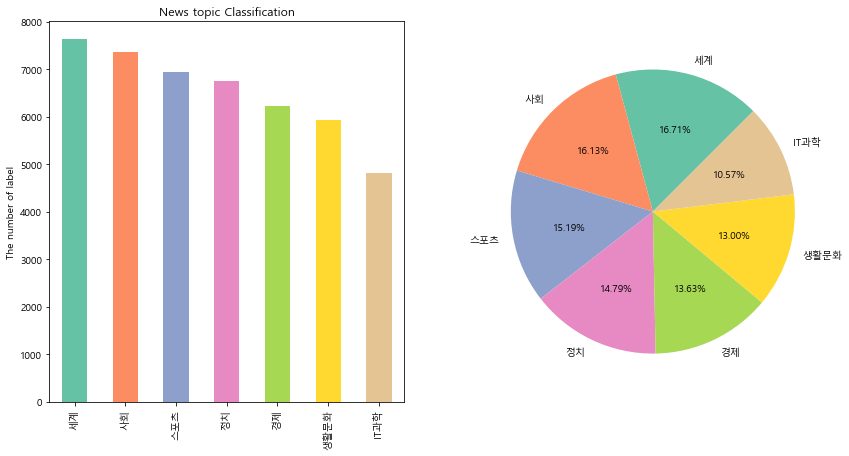

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))

colors = cm.get_cmap('Set2')(np.arange(7))

EDA['topic'].value_counts().plot.bar(ax=axes[0], color = colors, title = 'News topic Classification',ylabel = 'The number of label')

axes[1].pie(EDA['topic'].value_counts(),  autopct = "%.2f%%", 
            labels = EDA['topic'].value_counts().index, startangle = 45, colors = colors)

plt.show()

### (2) Train 데이터의 뉴스 Title 길이
- train 데이터와 test 데이터 간의 뉴스 Title의 길이 차이는 크게 차이가 없음(Insight는 없음)

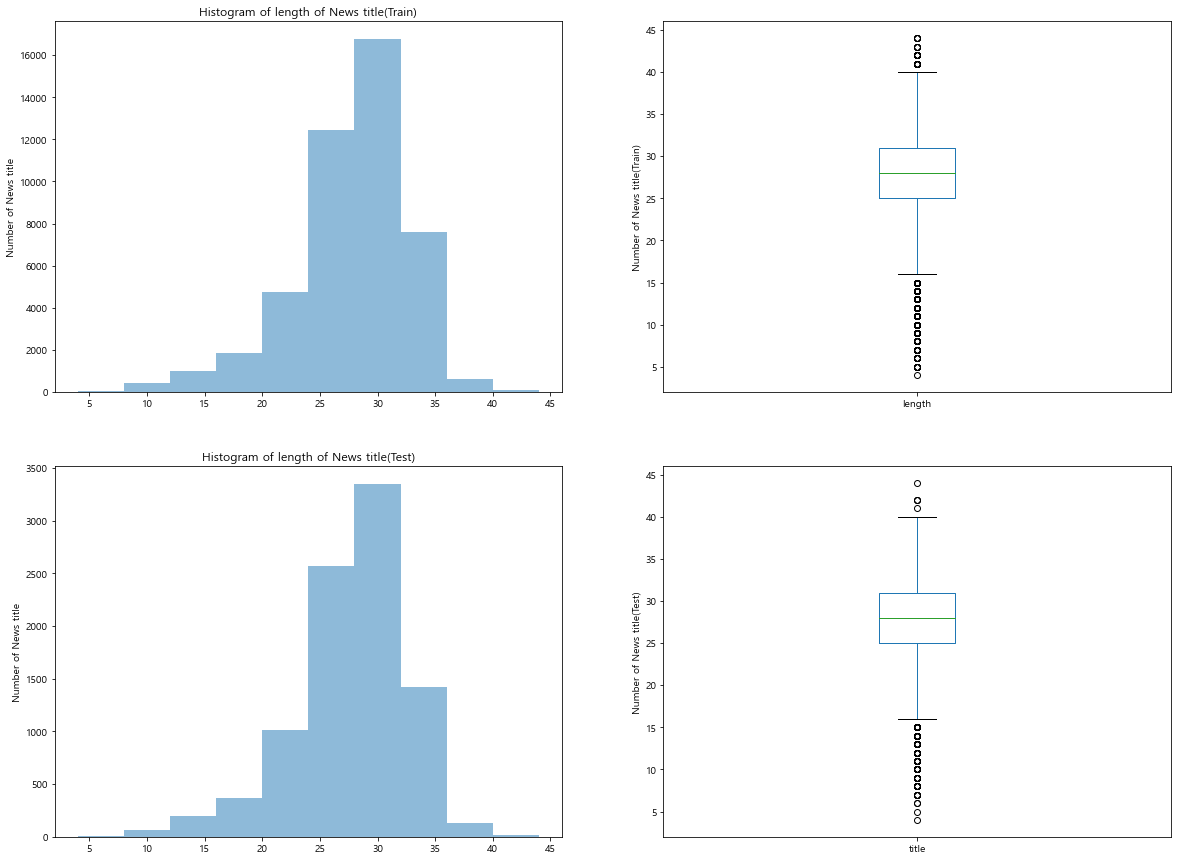

In [142]:
# (2) Train 데이터의 뉴스 Title 길이
EDA['length'] = EDA['title'].map(lambda x: len(x))

fig, axes= plt.subplots(2,2, figsize=(20,15))
axes[0,0].hist(EDA['length'], bins=10, alpha=0.5, label='word')
axes[0,0].set_title('Histogram of length of News title(Train)')
axes[0,0].set_ylabel('Number of News title')

EDA['length'].plot.box(ax = axes[0,1]) 
axes[0,1].set_ylabel('Number of News title(Train)')

axes[1,0].hist(test['title'].map(lambda x: len(x)), bins=10, alpha=0.5, label='word')
axes[1,0].set_title('Histogram of length of News title(Test)')
axes[1,0].set_ylabel('Number of News title')

test['title'].map(lambda x: len(x)).plot.box(ax = axes[1,1]) 
axes[1,1].set_ylabel('Number of News title(Test)')
plt.show()

(3) 각 Topic별로 Title의 분포
- 각 Topic별 boxplot의 큰 차이는 없어보임 / volinplot을 보게 되면 '생활/문화, 사회, 정치" 정도 낮아짐
- 각 Topic별 histgram의 차이는 조금씩 차이

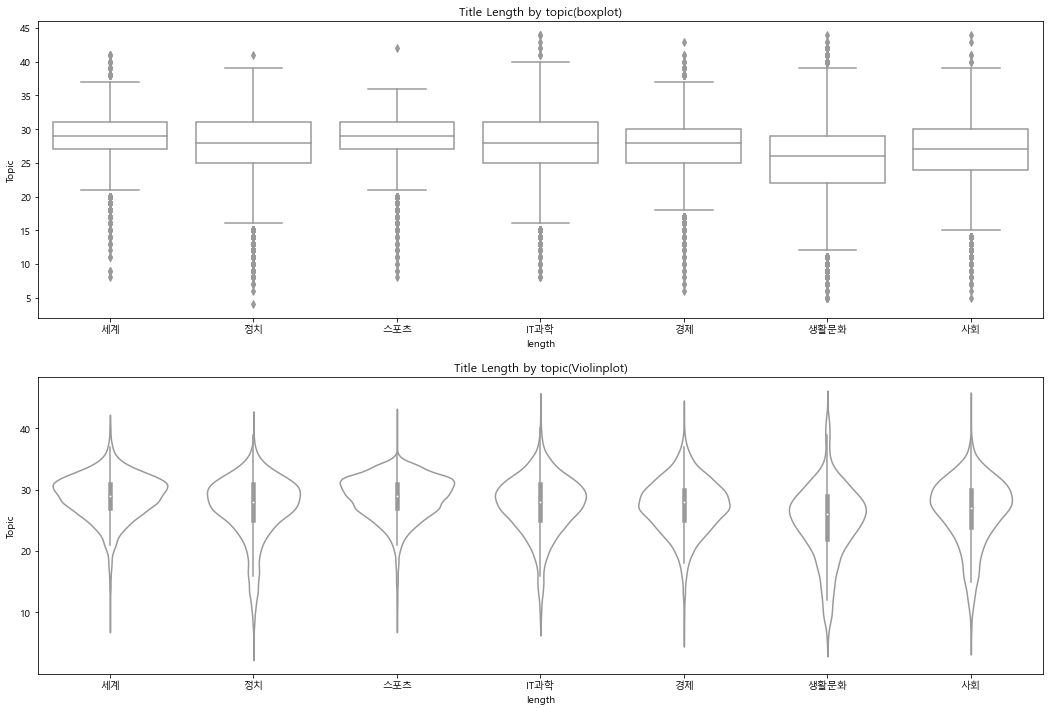

In [143]:
# 각 Topic 별 Title분포(box / violin)
fig, ax = plt.subplots(2,1, figsize=(18, 12))
sns.boxplot(x="topic", y="length", data = EDA, color='white', ax = ax[0])
ax[0].set_title('Title Length by topic(boxplot)')
ax[0].set_xlabel('length')
ax[0].set_ylabel('Topic')

sns.violinplot(x="topic", y="length", data = EDA, color='white', ax = ax[1])
ax[1].set_title('Title Length by topic(Violinplot)')
ax[1].set_xlabel('length')
ax[1].set_ylabel('Topic')
plt.show()

### (3) - 2 각 topic별 boxplot과 histogram
- 각 Topic의 histogram의 봉오리의 차이가 조금 다를 뿐 주요 분포(25 ~ 35)는 동일

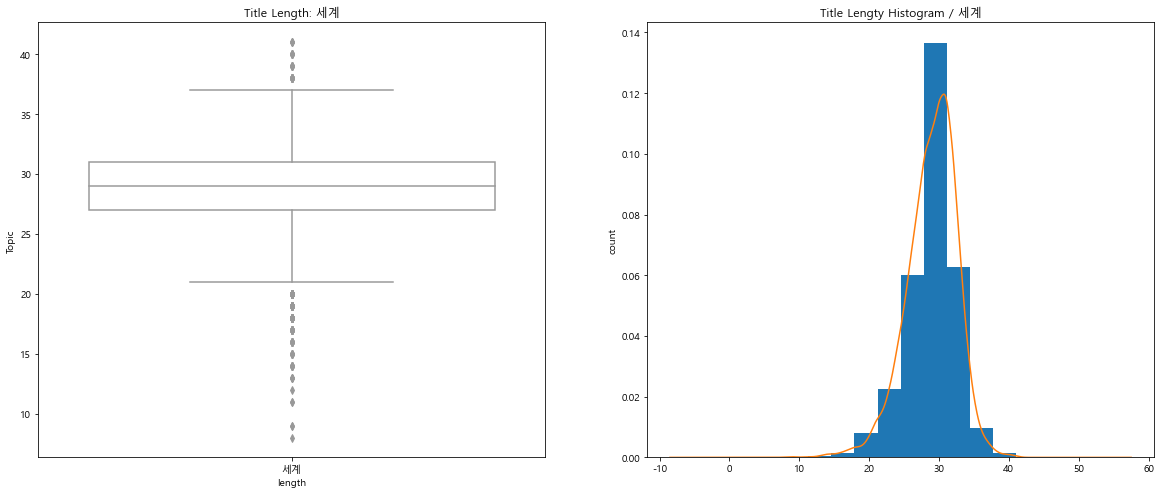

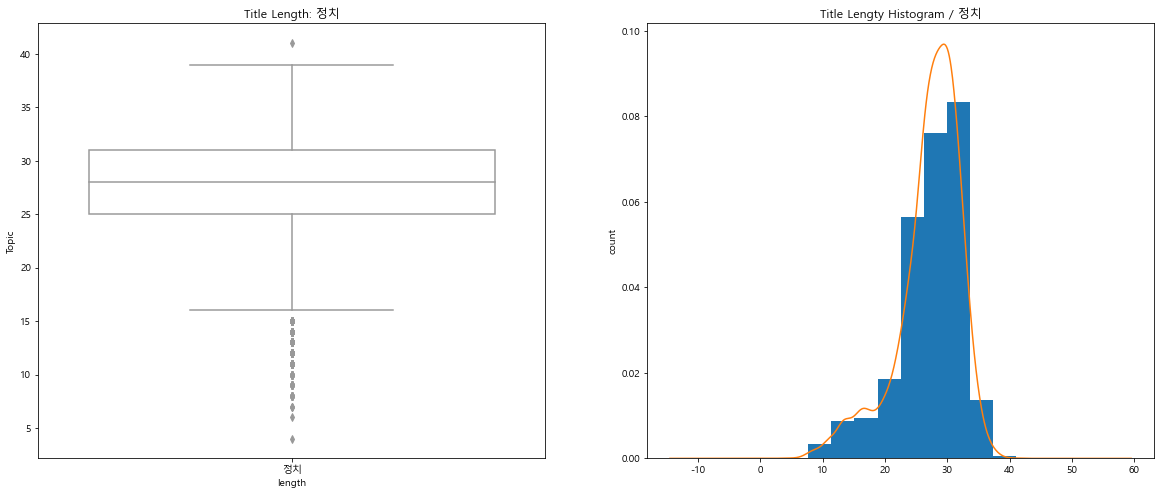

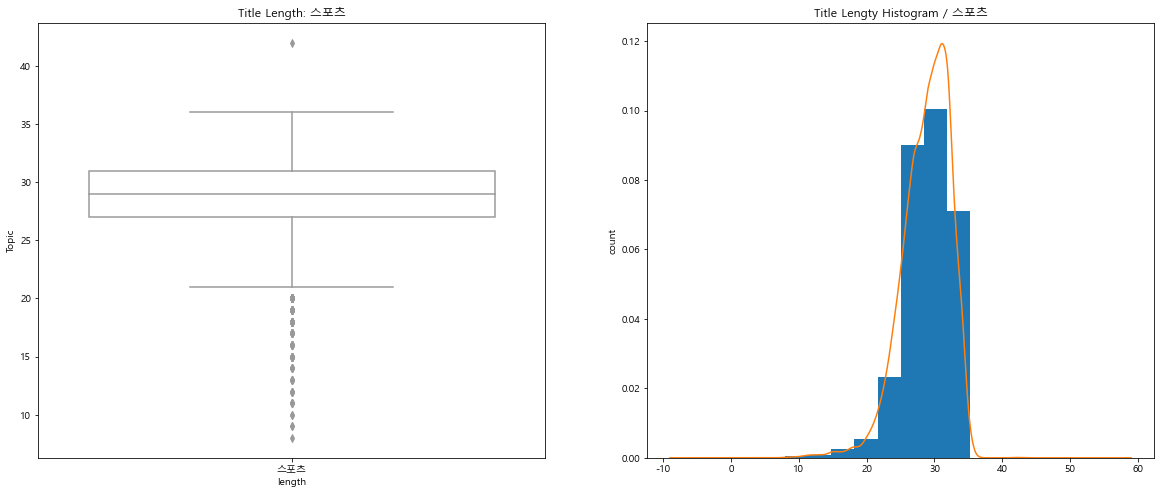

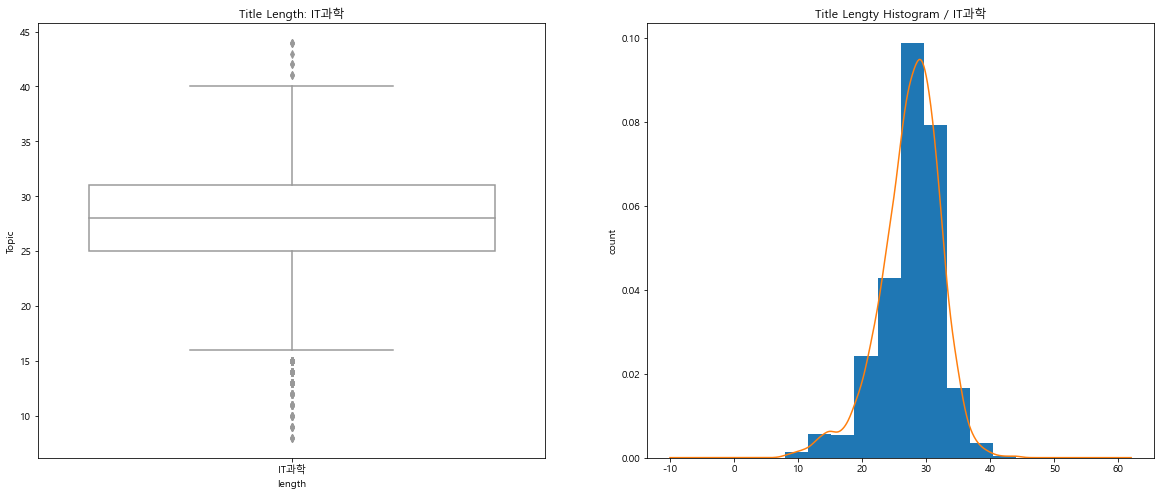

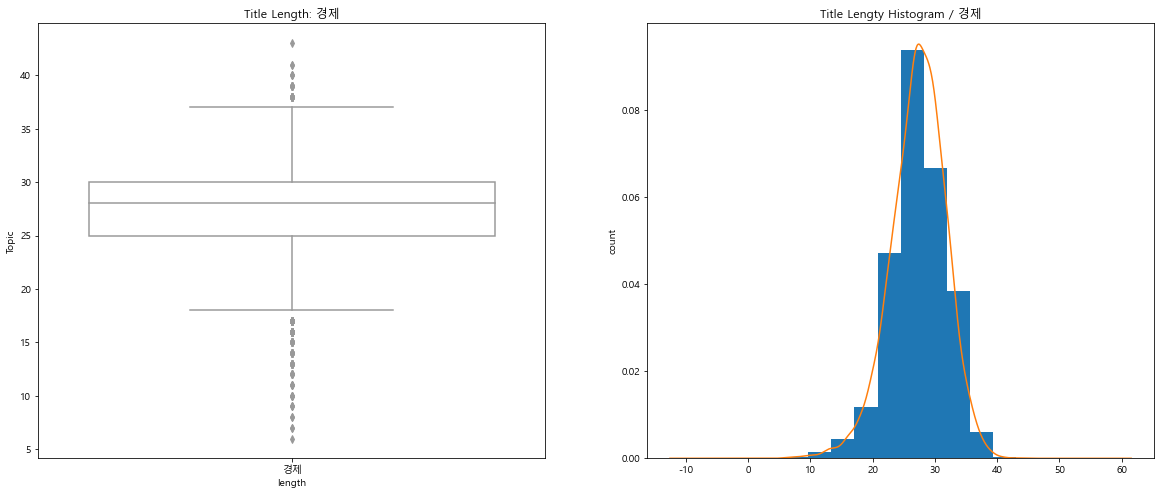

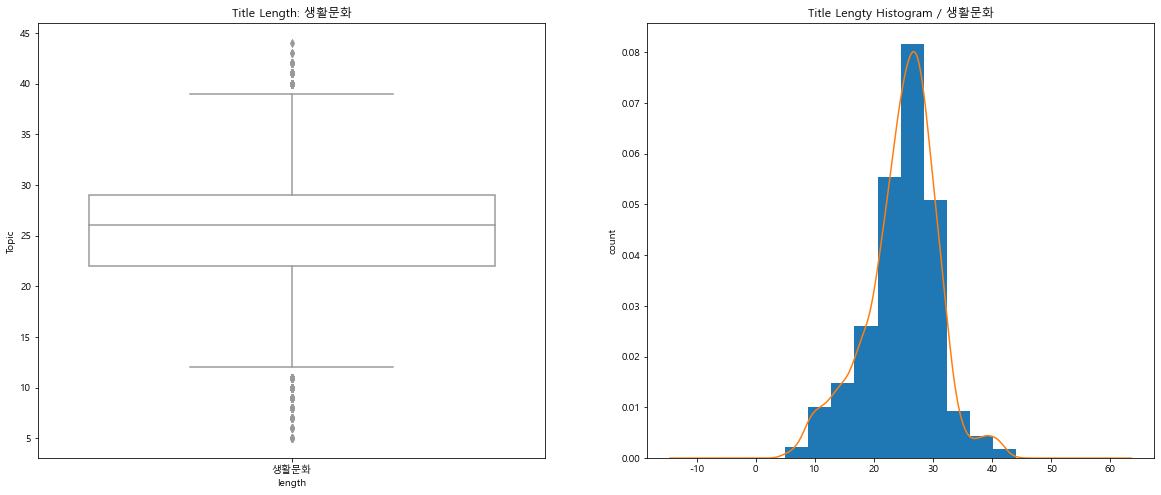

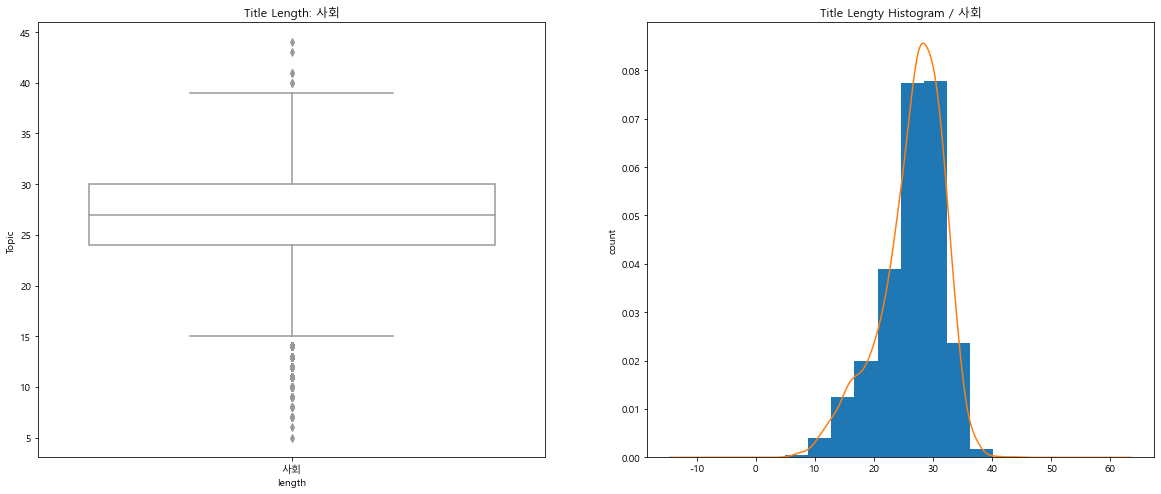

In [144]:
def topic(topic_list):
    for topic in topic_list:
        data = EDA[EDA.topic == topic]
        fig, ax = plt.subplots(1,2, figsize=(20, 8))
        sns.boxplot(x="topic", y="length", data = data, color='white', ax = ax[0])
        ax[0].set_title('Title Length: {}'.format(topic))
        ax[0].set_xlabel('length')
        ax[0].set_ylabel('Topic')
        
        data['length'].hist(ax = ax[1], bins = 10, alpha =1 ,density = True)
        data['length'].plot.density(ax=ax[1])
        ax[1].set_title('Title Lengty Histogram / {}'.format(topic))
        ax[1].set_ylabel('count')
        
topic(list(EDA.topic.unique()))

### (3)-3 각 Topic 별 뉴스 Title의 단어 수 (우선은 띄어쓰기 기준)
- 세계, 스포츠, 정치가 대체로 조금 길다
- 하지만 띄어쓰기 기준으로 해서 정확하지는 않음

In [145]:
EDA['words_num'] = EDA.title.apply(lambda x: len(x.split(' ')))

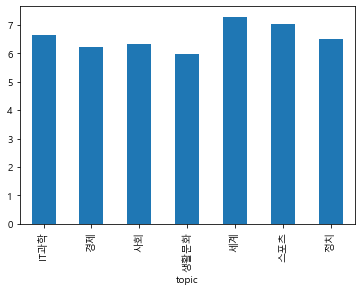

In [146]:
EDA.groupby('topic')['words_num'].mean().plot.bar();

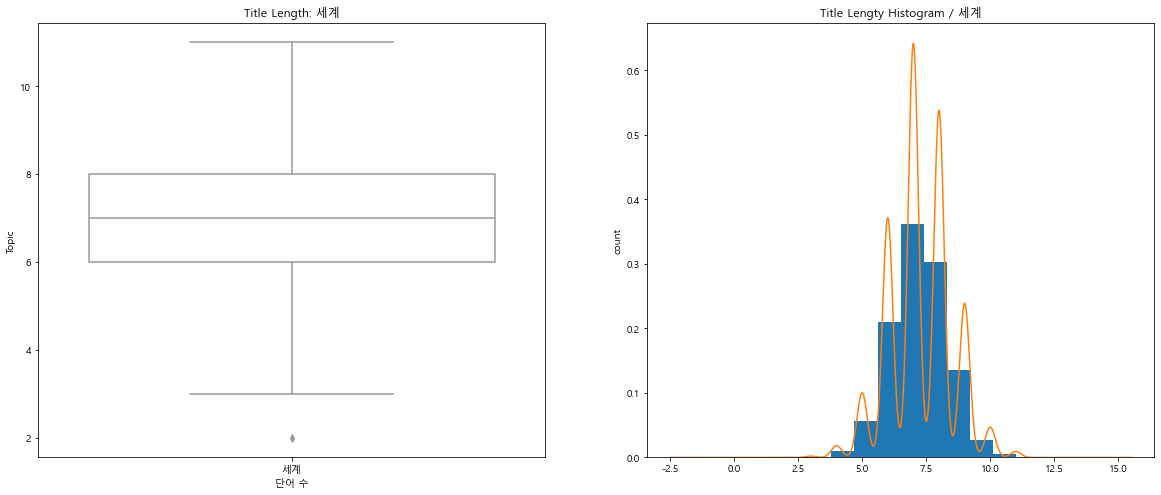

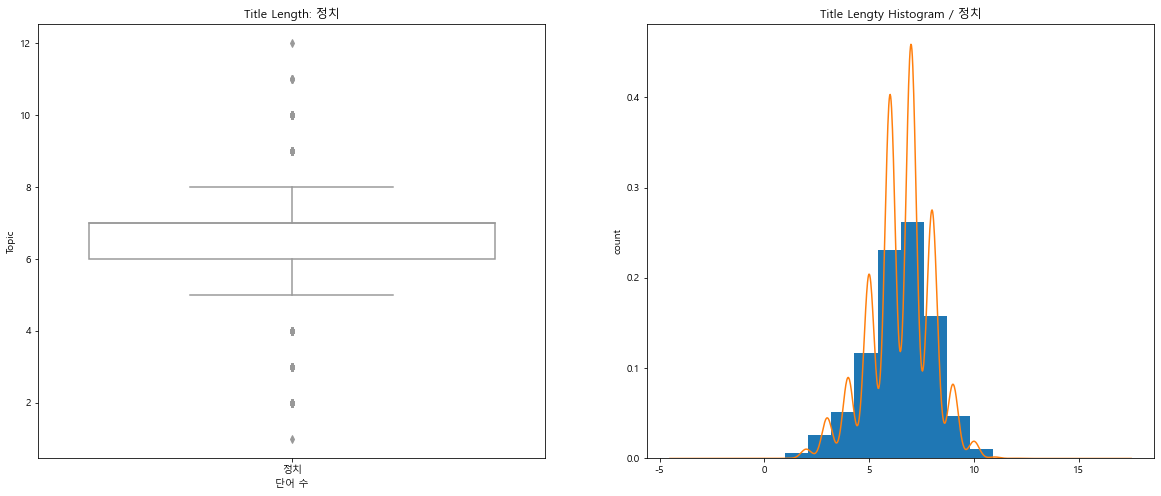

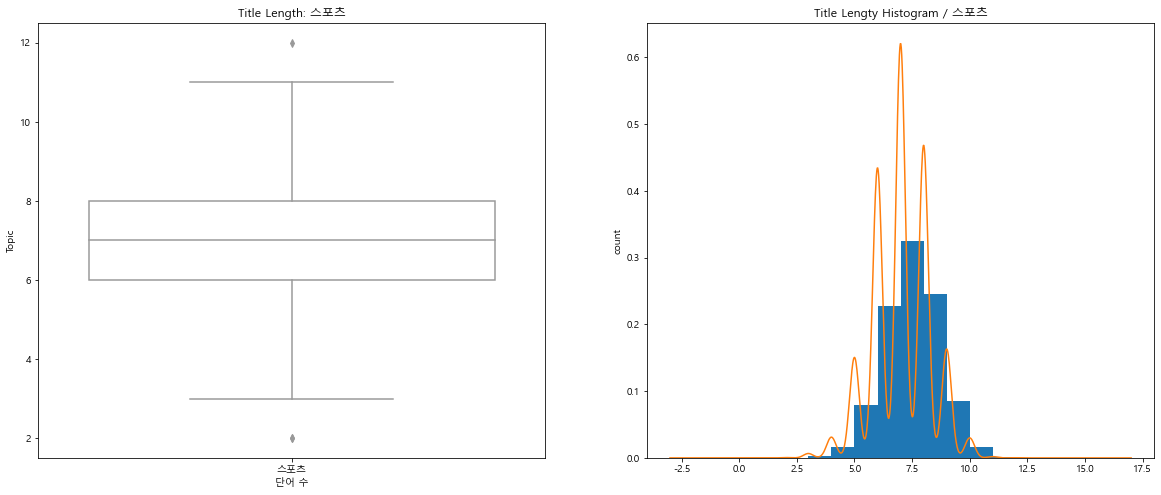

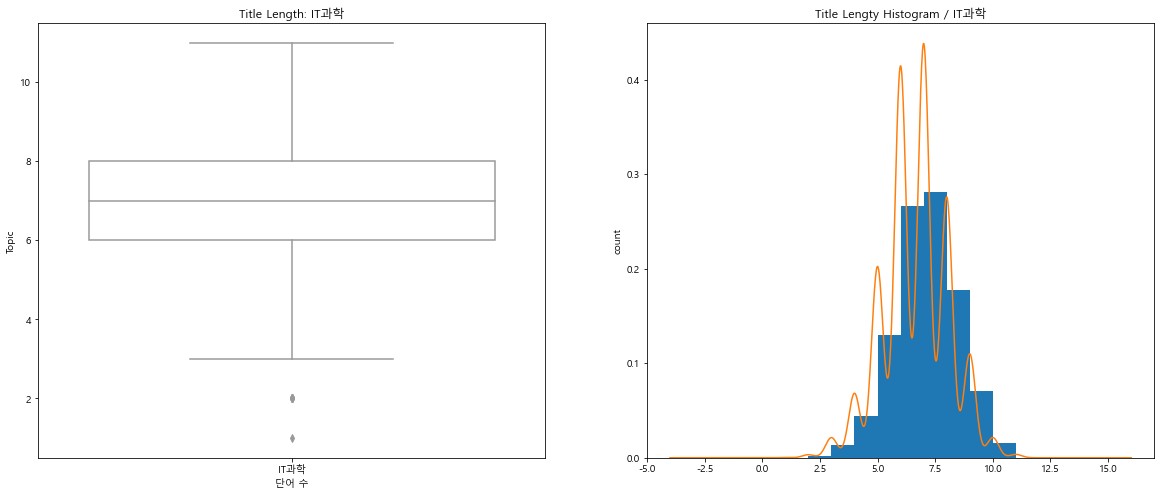

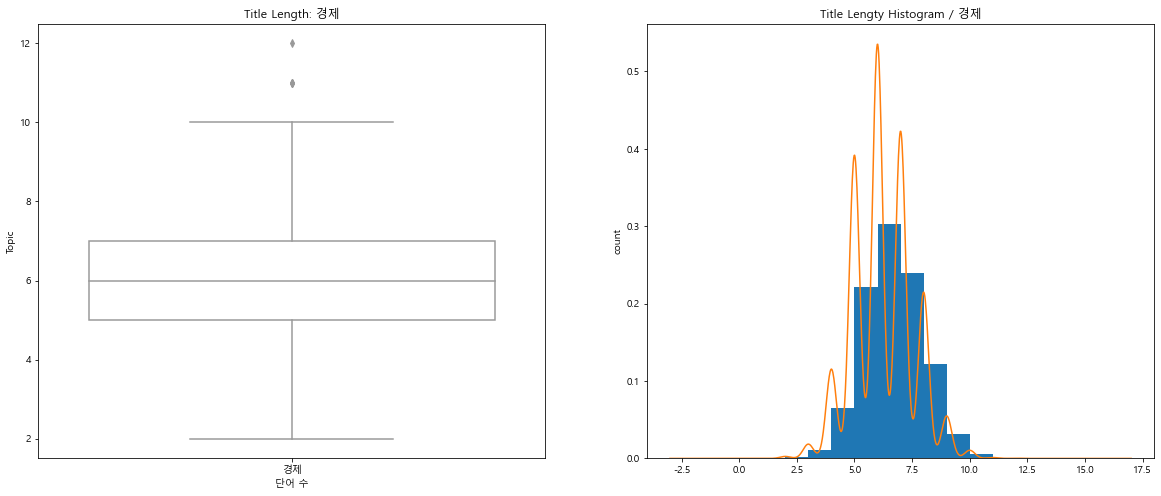

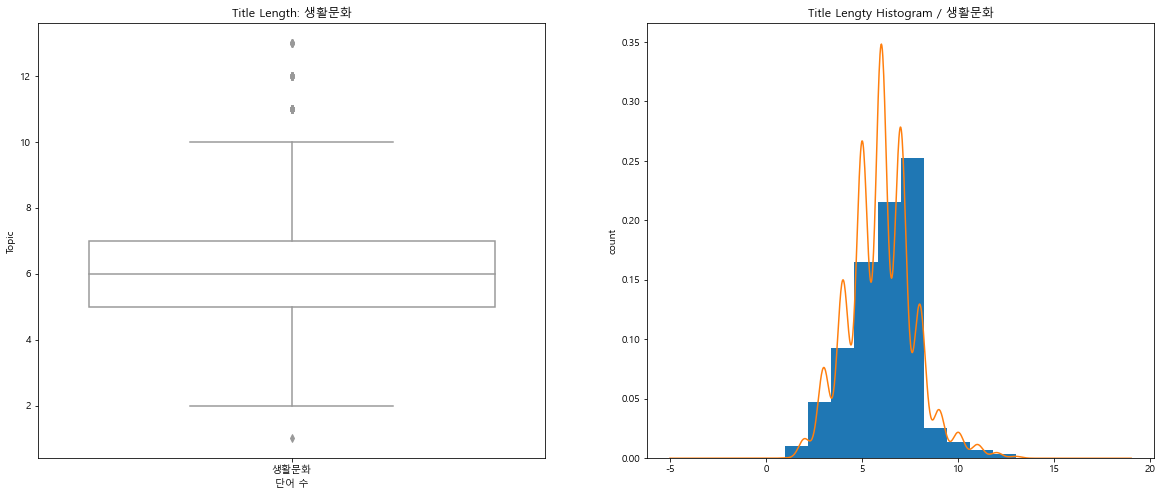

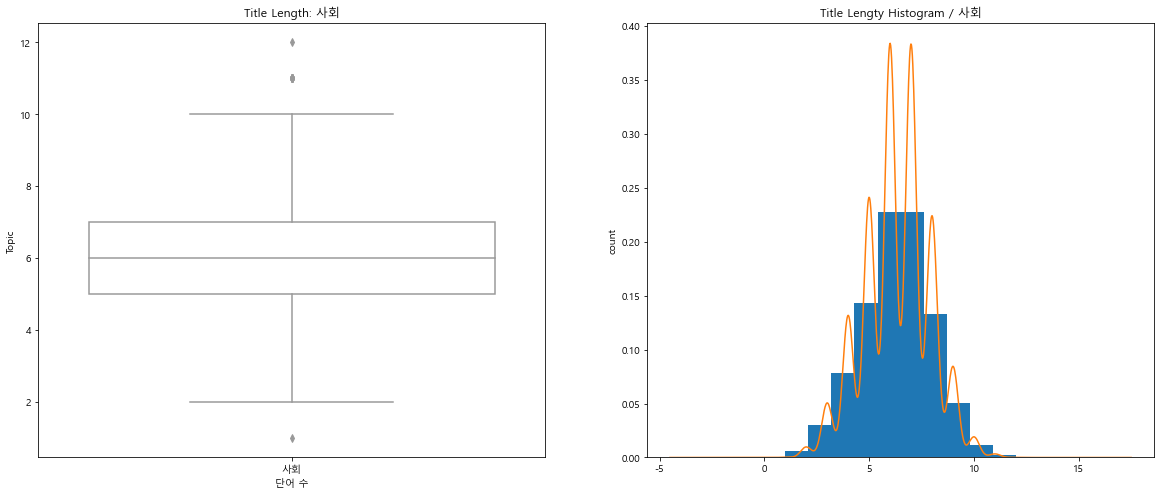

In [147]:
def topic(topic_list):
    for topic in topic_list:
        data = EDA[EDA.topic == topic]
        fig, ax = plt.subplots(1,2, figsize=(20, 8))
        sns.boxplot(x="topic", y="words_num", data = data, color='white', ax = ax[0])
        ax[0].set_title('Title Length: {}'.format(topic))
        ax[0].set_xlabel('단어 수')
        ax[0].set_ylabel('Topic')
        
        data['words_num'].hist(ax = ax[1], bins = 10, alpha =1 ,density = True)
        data['words_num'].plot.density(ax=ax[1])
        ax[1].set_title('Title Lengty Histogram / {}'.format(topic))
        ax[1].set_ylabel('count')
        
topic(list(EDA.topic.unique()))

### 4. 한국어 이외의 단어들의 존재
#### (1) 숫자(월, 년도 등등) 등장 횟수 : 경제가 대체로 많았고 정치에 눈에띄게 적음

In [148]:
def num_char(data):
    num = re.compile(r'\d+')
    num_data = num.findall(data)
    return num_data

EDA['Num_char'] = EDA['title'].agg(lambda x : num_char(x))
EDA['Num_char_length'] = EDA['Num_char'].agg(lambda x: len(x))

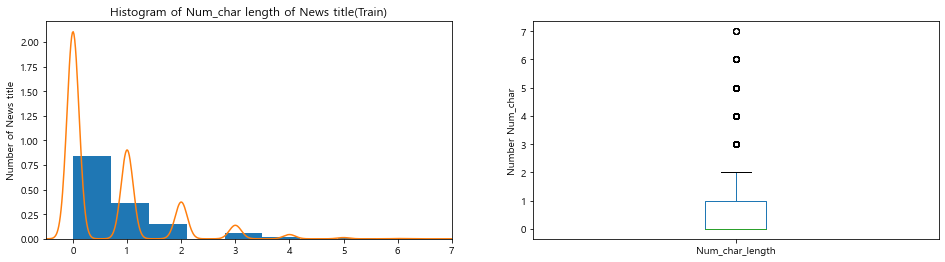

In [149]:
#### 뉴스 토픽에서 숫자 등장 횟수 분포
fig, axes= plt.subplots(1,2, figsize=(16,4))
axes[0].hist(EDA['Num_char_length'], bins=10, alpha=1, label='word', density = True)
EDA['Num_char_length'].plot.density(ax=axes[0])
axes[0].set_title('Histogram of Num_char length of News title(Train)')
axes[0].set_ylabel('Number of News title')
axes[0].set_xlim([-0.5,7])

EDA['Num_char_length'].plot.box(ax = axes[1]) 
axes[1].set_ylabel('Number Num_char')

plt.show()

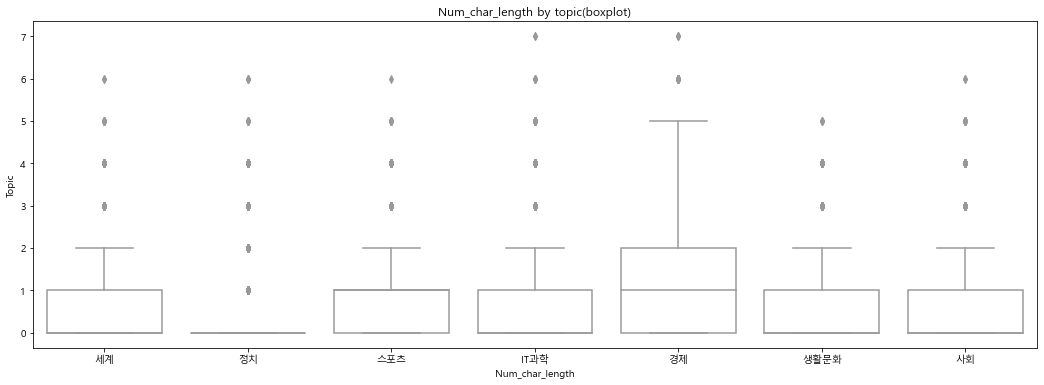

In [150]:
# 각 Topic 별 숫자 포함 개수: 경제가 가장 많음. 정치가 가장 없음
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="topic", y="Num_char_length", data = EDA, color='white', ax = ax)
ax.set_title('Num_char_length by topic(boxplot)')
ax.set_xlabel('Num_char_length')
ax.set_ylabel('Topic')
plt.show()

#### (2) 점 콤마 등 포함 횟수(의미가 없었음 주제별로 비슷)

In [151]:
def num_char(data):
    num = re.compile(r'\W')
    num_data = num.findall(data)
    return num_data

EDA['Num_j'] = EDA['title'].agg(lambda x : num_char(x))
EDA['Num_j_length'] = EDA['Num_j'].agg(lambda x: len(x))
EDA

,title,topic_idx,topic,length,words_num,Num_char,Num_char_length,Num_j,Num_j_length
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,[],0,"[→, , , …, , ]",6
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6,[15],1,"[ , …, , , , ]",6
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8,[],0,"[ , , , , , , ]",7
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7,[],0,"[ , , , , …, , ]",7
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7,[],0,"[ , , , , , ]",6
...,...,...,...,...,...,...,...,...,...
45649,창원 시내버스 노조 파업 투표 가결…30일 운행 멈춘다종합,2,사회,32,8,[30],1,"[ , , , , , …, , ]",8
45650,남친과 함께 잔혹하게 동거인 학대 20대 여성 구속영장,2,사회,30,8,[20],1,"[ , , , , , , ]",7
45651,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,사회,31,7,[1],1,"[ , , , , , ·, ]",7
45652,답변하는 배기동 국립중앙박물관장,2,사회,17,3,[],0,"[ , ]",2


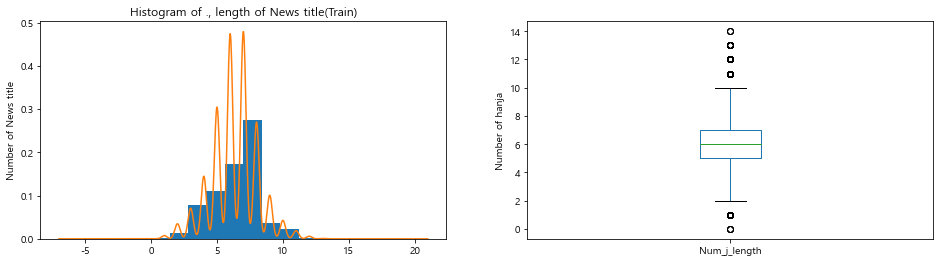

In [152]:
#### 뉴스 토픽에서 ., 등장 횟수 분포
fig, axes= plt.subplots(1,2, figsize=(16,4))
axes[0].hist(EDA['Num_j_length'], bins=10, alpha=1, label='word', density = True)
EDA['Num_j_length'].plot.density(ax=axes[0])
axes[0].set_title('Histogram of ., length of News title(Train)')
axes[0].set_ylabel('Number of News title')

EDA['Num_j_length'].plot.box(ax = axes[1]) 
axes[1].set_ylabel('Number of hanja')

plt.show()

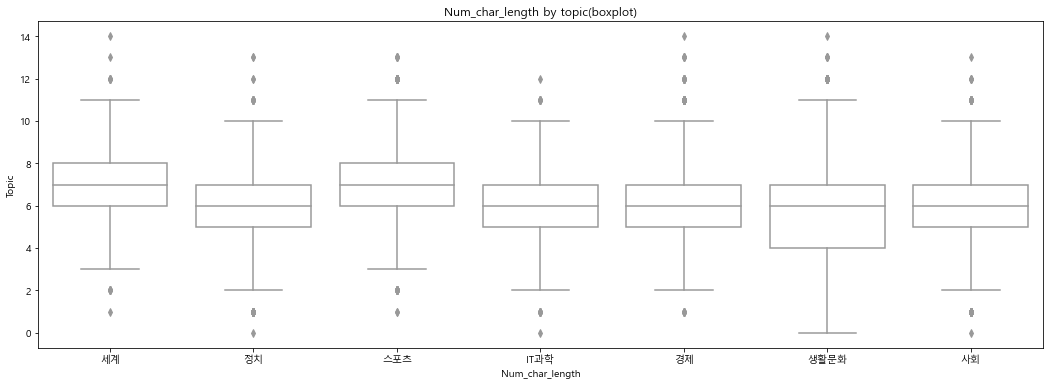

In [153]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="topic", y="Num_j_length", data = EDA, color='white', ax = ax)
ax.set_title('Num_char_length by topic(boxplot)')
ax.set_xlabel('Num_char_length')
ax.set_ylabel('Topic')
plt.show()

#### (3) 한자 등장 횟수: 세계, 정치 에서 높았음

In [154]:
def num_char(data):
    num = re.compile(r'[一-龥]')
    num_data = num.findall(data)
    return num_data

EDA['Num_h'] = EDA['title'].agg(lambda x : num_char(x))
EDA['Num_h_length'] = EDA['Num_h'].agg(lambda x: len(x))
EDA

,title,topic_idx,topic,length,words_num,Num_char,Num_char_length,Num_j,Num_j_length,Num_h,Num_h_length
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,[],0,"[→, , , …, , ]",6,[],0
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6,[15],1,"[ , …, , , , ]",6,[美],1
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8,[],0,"[ , , , , , , ]",7,[],0
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7,[],0,"[ , , , , …, , ]",7,[韓],1
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7,[],0,"[ , , , , , ]",6,[],0
...,...,...,...,...,...,...,...,...,...,...,...
45649,창원 시내버스 노조 파업 투표 가결…30일 운행 멈춘다종합,2,사회,32,8,[30],1,"[ , , , , , …, , ]",8,[],0
45650,남친과 함께 잔혹하게 동거인 학대 20대 여성 구속영장,2,사회,30,8,[20],1,"[ , , , , , , ]",7,[],0
45651,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,사회,31,7,[1],1,"[ , , , , , ·, ]",7,[],0
45652,답변하는 배기동 국립중앙박물관장,2,사회,17,3,[],0,"[ , ]",2,[],0


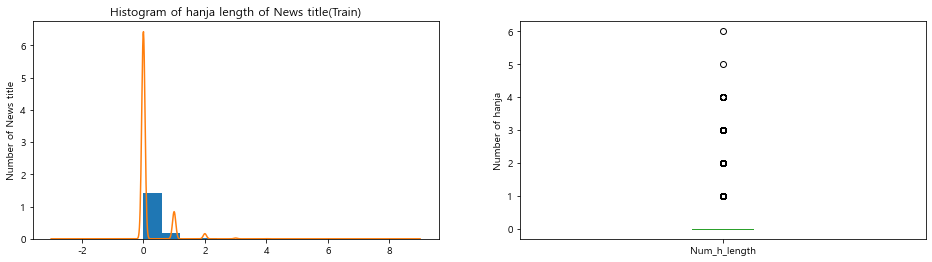

In [155]:
#### 뉴스 토픽에서 한자 등장 횟수 분포
fig, axes= plt.subplots(1,2, figsize=(16,4))
axes[0].hist(EDA['Num_h_length'], bins=10, alpha=1, label='word', density = True)
EDA['Num_h_length'].plot.density(ax=axes[0])
axes[0].set_title('Histogram of hanja length of News title(Train)')
axes[0].set_ylabel('Number of News title')

EDA['Num_h_length'].plot.box(ax = axes[1]) 
axes[1].set_ylabel('Number of hanja')

plt.show()

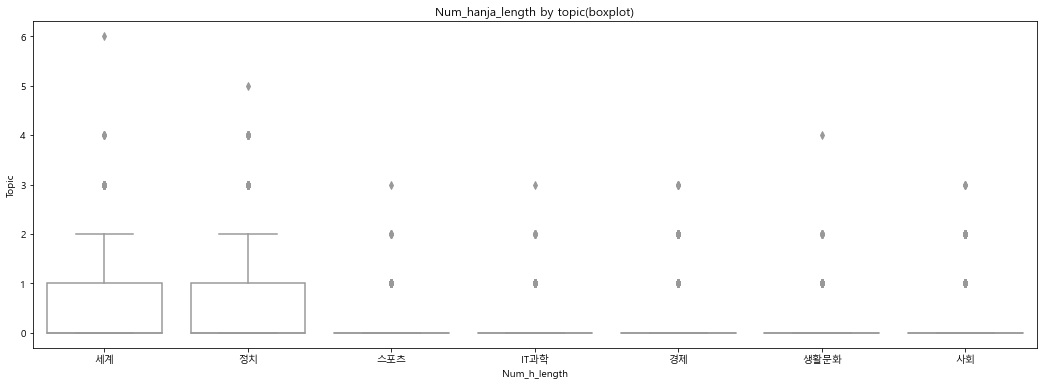

In [156]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="topic", y="Num_h_length", data = EDA, color='white', ax = ax)
ax.set_title('Num_hanja_length by topic(boxplot)')
ax.set_xlabel('Num_h_length')
ax.set_ylabel('Topic')
plt.show()

#### (4) 영어 등장 횟수(대소문자 모두 포함) : it과학, 스포츠, 경제에서 가장 많았음

In [160]:
def num_char(data):
    num = re.compile(r'[a-zA-Z]')
    num_data = num.findall(data)
    return num_data

EDA['Num_e'] = EDA['title'].agg(lambda x : num_char(x))
EDA['Num_e_length'] = EDA['Num_e'].agg(lambda x: len(x))
EDA

,title,topic_idx,topic,length,words_num,Num_char,Num_char_length,Num_j,Num_j_length,Num_h,Num_h_length,Num_e,Num_e_length
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,세계,24,5,[],0,"[→, , , …, , ]",6,[],0,[],0
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,세계,30,6,[15],1,"[ , …, , , , ]",6,[美],1,[],0
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,세계,30,8,[],0,"[ , , , , , , ]",7,[],0,[],0
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,세계,32,7,[],0,"[ , , , , …, , ]",7,[韓],1,"[N, Y, T]",3
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,세계,25,7,[],0,"[ , , , , , ]",6,[],0,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45649,창원 시내버스 노조 파업 투표 가결…30일 운행 멈춘다종합,2,사회,32,8,[30],1,"[ , , , , , …, , ]",8,[],0,[],0
45650,남친과 함께 잔혹하게 동거인 학대 20대 여성 구속영장,2,사회,30,8,[20],1,"[ , , , , , , ]",7,[],0,[],0
45651,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,사회,31,7,[1],1,"[ , , , , , ·, ]",7,[],0,[],0
45652,답변하는 배기동 국립중앙박물관장,2,사회,17,3,[],0,"[ , ]",2,[],0,[],0


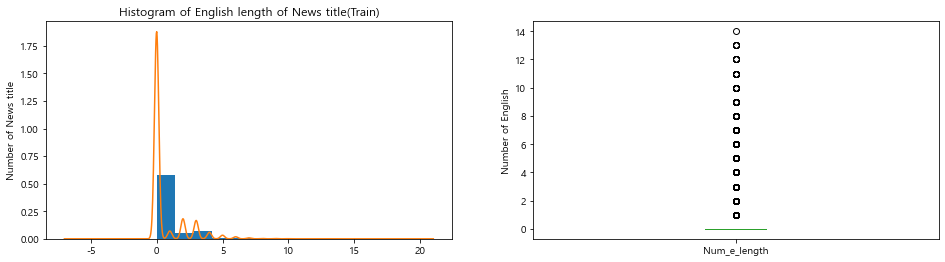

In [161]:
#### 뉴스 토픽에서 영어 등장 횟수 분포
fig, axes= plt.subplots(1,2, figsize=(16,4))
axes[0].hist(EDA['Num_e_length'], bins=10, alpha=1, label='word', density = True)
EDA['Num_e_length'].plot.density(ax=axes[0])
axes[0].set_title('Histogram of English length of News title(Train)')
axes[0].set_ylabel('Number of News title')

EDA['Num_e_length'].plot.box(ax = axes[1]) 
axes[1].set_ylabel('Number of English')

plt.show()

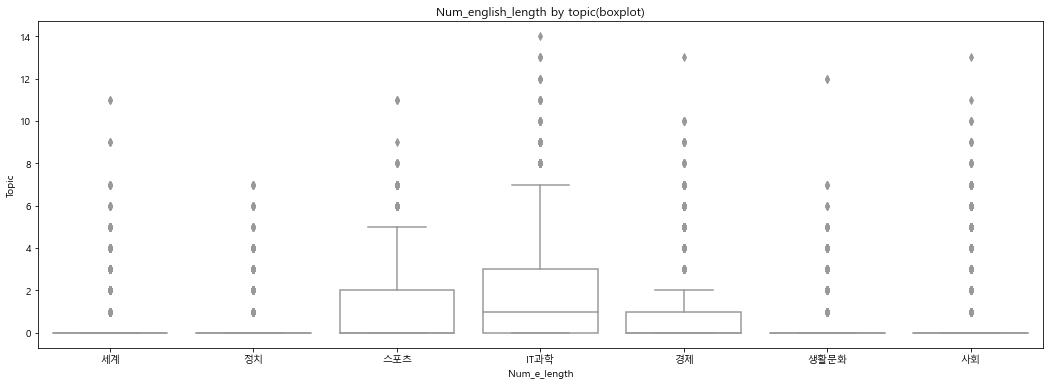

In [162]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="topic", y="Num_e_length", data = EDA, color='white', ax = ax)
ax.set_title('Num_english_length by topic(boxplot)')
ax.set_xlabel('Num_e_length')
ax.set_ylabel('Topic')
plt.show()

#### (2) 한자어

In [ ]:
new = EDA['title'][30000]

In [ ]:
special_char = re.compile(r'[^A-Za-z0-9가-힣+]')
special_char_data = special_char.findall(new)

In [ ]:
special_char_data

In [ ]:
def special_char(data):
    special_char = re.compile(r'[^ A-Za-z0-9가-힣+]')
    special_char_data = special_char.findall(data)
    for i in special_char_data:
        
        return special_char_data 
EDA['title'].agg(lambda x: special_char(x))

In [ ]:
EDA['title'].agg(lambda x: special_char(x))[300]

In [ ]:
import re
p = re.compile(r'\([\u2E80-\u2EFF\u3400-\u4DBF\u4E00-\u9FBF\uF900-\uFAFF\u20000-\u2A6DF\u2F800-\u2FA1F]+\)')

In [ ]:
p.findall(EDA['title'][300])

#### hanja모듈 사용 예시

In [ ]:
# !pip install hanja

In [ ]:
import hanja
from hanja import hangul
hanja.translate('大韓民國은 民主共和國이다.', 'substitution')

In [ ]:
# 옵션을 combination으로 주면 괄호로 표시됨
import requests
from bs4 import BeautifulSoup

text = hanja.translate('大韓民國은 民主共和國이다.', 'combination')
soup = BeautifulSoup(text, 'html.parser')
print(soup.text)

### 한자만 뽑아내기

In [ ]:
# 유니코드 한자 범위: (한중일 통합 한자)
r = "\U00004e00-\U00009fff"

def get_hanja(xyz): # 한자를 뽑아내는 함수
    chop = re.match("[{}]".format(r), xyz)
    if chop:
        return chop.group(0)  

In [ ]:
list_hanja = []; list_hanja_idx = []
for index, row in EDA.iterrows():
    hanja = get_hanja(row['title'])
    if hanja:
        list_hanja.append(hanja)
        list_hanja_idx.append(index)
        
list_hanja

In [ ]:
list_hanja_idx

### 한자를 한글로 변환하기

In [ ]:
import hanja
from hanja import hangul
hanjatransfer = []
for index, row in EDA.iterrows():
        hanjatransfer.append(hanja.translate(row['title'], 'substitution'))

In [ ]:
EDA['hanjatrans']= hanjatransfer
EDA.hanjatrans

In [ ]:
hanjatransfer_test = []
for index, row in test.iterrows():
        hanjatransfer_test.append(hanja.translate(row['title'], 'substitution'))

In [ ]:
test['hanjatrans']= hanjatransfer_test
test

In [ ]:
#test.to_csv('test_hanja.csv')
#EDA.to_csv('train_hanja.csv')